In [1]:
!pip install GPy
!pip install GPyOpt
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reduce the dataset size
x_train, x_test = x_train[:10000], x_test[:2000]
y_train, y_test = y_train[:10000], y_test[:2000]

# Split the data into training and temporary set
x_train, x_temp, y_train, y_temp = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Start recording time
start_time = time.time()

best_train_losses = []
best_train_accuracies = []
best_val_losses = []
best_val_accuracies = []
best_test_losses = []
best_test_accuracies = []
global_best_accuracy = 0

def create_model(params):
    global best_train_losses
    global best_train_accuracies
    global best_val_losses
    global best_val_accuracies
    global best_test_losses
    global best_test_accuracies
    global global_best_accuracy
    
    optimizer_mapping = {0: 'adam', 1: 'sgd', 2: 'rmsprop', 3: 'adagrad'}
    activation_mapping = {0: 'relu', 1: 'tanh', 2: 'elu'}
    batch_size_mapping = {0: 32, 1: 64, 2: 128}
    kernel_size_mapping = {0: (3, 3), 1: (5, 5)}

    params = params.flatten()

    num_conv_layers = int(params[0])
    num_filters = int(params[1])
    dropout_rate = params[2]
    optimizer = optimizer_mapping[int(params[3])]
    learning_rate = params[4]
    activation = activation_mapping[int(params[5])]
    epochs = int(params[6])
    batch_size = batch_size_mapping[int(params[7])]
    kernel_size = kernel_size_mapping[int(params[8])]
    reg_lambda = params[9]

    model = tf.keras.models.Sequential()

    for i in range(num_conv_layers):
        if i == 0:
            model.add(tf.keras.layers.Conv2D(num_filters, kernel_size, activation=activation, padding='same', input_shape=(32, 32, 3), kernel_regularizer=l2(reg_lambda)))
        else:
            model.add(tf.keras.layers.Conv2D(num_filters, kernel_size, activation=activation, padding='same', kernel_regularizer=l2(reg_lambda)))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation=activation, kernel_regularizer=l2(reg_lambda)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    # Initialize best_accuracy to 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    test_losses = []  # Initialize test_losses list
    test_accuracies = []  # Initialize test_accuracies list
    best_accuracy = 0

    for epoch in range(epochs):
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=batch_size, verbose=0, callbacks=[early_stopping, model_checkpoint])
        
        # Accumulate loss and accuracy values
        train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
        val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)  # Evaluate on validation data
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)  # Append test loss for each epoch

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)  # Append test accuracy for each epoch

        # If this epoch improves accuracy for this model, update best_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
    
    # If this model improves global accuracy, update global best losses and accuracies
    if best_accuracy > global_best_accuracy:
        global_best_accuracy = best_accuracy
        best_train_losses = train_losses.copy()
        best_train_accuracies = train_accuracies.copy()
        best_val_losses = val_losses.copy()
        best_val_accuracies = val_accuracies.copy()
        best_test_losses = test_losses.copy()  # Copy test_losses list
        best_test_accuracies = test_accuracies.copy()  # Copy test_accuracies list

    score = model.evaluate(x_test, y_test, verbose=0)
    return model, score[1]

# Define the domain (or the range of hyperparameters)
domain = [
    {'name': 'num_conv_layers', 'type': 'discrete', 'domain': (2, 3, 4, 5)},
    {'name': 'num_filters', 'type': 'discrete', 'domain': (32, 64, 128, 256)},
    {'name': 'dropout_rate', 'type': 'continuous', 'domain': (0.2, 0.7)},
    {'name': 'optimizer', 'type': 'categorical', 'domain': (0, 1, 2, 3)},
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-6, 1e-2)},
    {'name': 'activation', 'type': 'categorical', 'domain': (0, 1, 2)},
    {'name': 'epochs', 'type': 'discrete', 'domain': tuple(range(0, 51))},
    {'name': 'batch_size', 'type': 'categorical', 'domain': (0, 1, 2)},
    {'name': 'kernel_size', 'type': 'categorical', 'domain': (0, 1)},
    {'name': 'reg_lambda', 'type': 'continuous', 'domain': (1e-5, 1e-1)},
]

def objective_function(params):
    _, accuracy = create_model(params)
    return accuracy

# Initialize the Bayesian optimizer
optimizer = BayesianOptimization(f=objective_function,
                                 domain=domain,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 acquisition_jitter=0.01,
                                 exact_feval=True,
                                 maximize=True)

# Run optimization
optimizer.run_optimization(max_iter=30)

param_names = [
    'num_conv_layers',
    'num_filters',
    'dropout_rate',
    'optimizer',
    'learning_rate',
    'activation',
    'epochs',
    'batch_size',
    'kernel_size',
    'reg_lambda'
]

optimizer_mapping = {0: 'adam', 1: 'sgd', 2: 'rmsprop', 3: 'adagrad'}
activation_mapping = {0: 'relu', 1: 'tanh', 2: 'elu'}
batch_size_mapping = {0: 32, 1: 64, 2: 128}
kernel_size_mapping = {0: (3, 3), 1: (5, 5)}

mapping_dict = {
    3: optimizer_mapping,
    5: activation_mapping,
    7: batch_size_mapping,
    8: kernel_size_mapping
}

optimized_params = optimizer.x_opt

for i, param_name in enumerate(param_names):
    if i in mapping_dict:
        print(f"{param_name}: {mapping_dict[i][int(optimized_params[i])]}")
    else:
        print(f"{param_name}: {optimized_params[i]}")

print("Maximum accuracy: ", -optimizer.fx_opt)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 13.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=1558887 sha256=503153f20fee23b4bba37495f908d8d25fbe2efa9aac40d2dd0f60c4d540b479
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102548 sha256=6a339e970339852af0cac6ba8514a56741459c092a726aaf3c78a597322878cf
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built GPy paramz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


170498071/170498071 [==============================] - 2s 0us/step
num_conv_layers: 2.0
num_filters: 256.0
dropout_rate: 0.7
optimizer: sgd
learning_rate: 0.01
activation: elu
epochs: 42.0
batch_size: 32
kernel_size: (3, 3)
reg_lambda: 1e-05
Maximum accuracy:  0.6000000238418579


In [2]:
# Print time taken by the code to run
end_time = time.time()
print("Time taken by the code to run: ", end_time - start_time, " seconds")

Time taken by the code to run:  4821.839736700058  seconds


In [3]:
# Get the best model and its accuracy
best_model, best_accuracy = create_model(optimized_params)

# Load the weights into the best model
best_model.load_weights('best_model.h5')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 1.1928426027297974
Test Accuracy: 0.5893333554267883


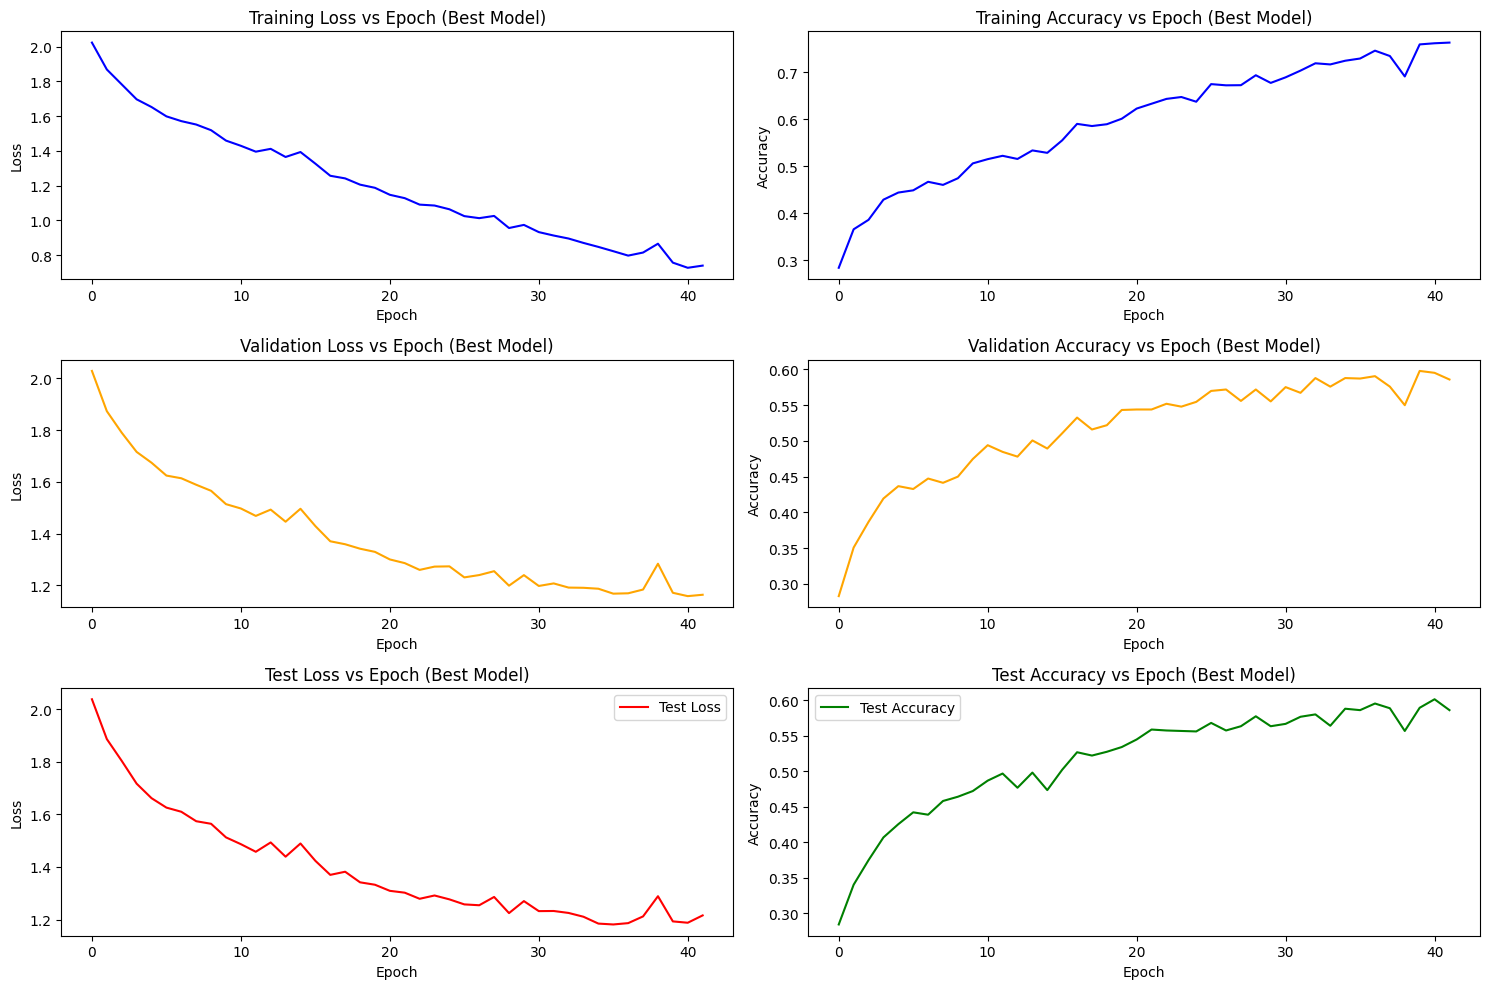

In [4]:
# Plotting
plt.figure(figsize=(15, 10))

# Training Loss vs Epoch
plt.subplot(3, 2, 1)
plt.plot(best_train_losses, label='Training Loss', color='blue')
plt.title('Training Loss vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Training Accuracy vs Epoch
plt.subplot(3, 2, 2)
plt.plot(best_train_accuracies, label='Training Accuracy', color='blue')
plt.title('Training Accuracy vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Validation Loss vs Epoch
plt.subplot(3, 2, 3)
plt.plot(best_val_losses, label='Validation Loss', color='orange')  
plt.title('Validation Loss vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Validation Accuracy vs Epoch
plt.subplot(3, 2, 4)
plt.plot(best_val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Test Loss vs Epoch for Best Test Loss
plt.subplot(3, 2, 5)
plt.plot(best_test_losses, label='Test Loss', color='red')  # Plotting best_test_losses
plt.title('Test Loss vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Test Accuracy vs Epoch for Best Test Accuracy
plt.subplot(3, 2, 6)
plt.plot(best_test_accuracies, label='Test Accuracy', color='green')  # Plotting best_test_accuracies
plt.title('Test Accuracy vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

47/47 [==============================] - 0s 3ms/step


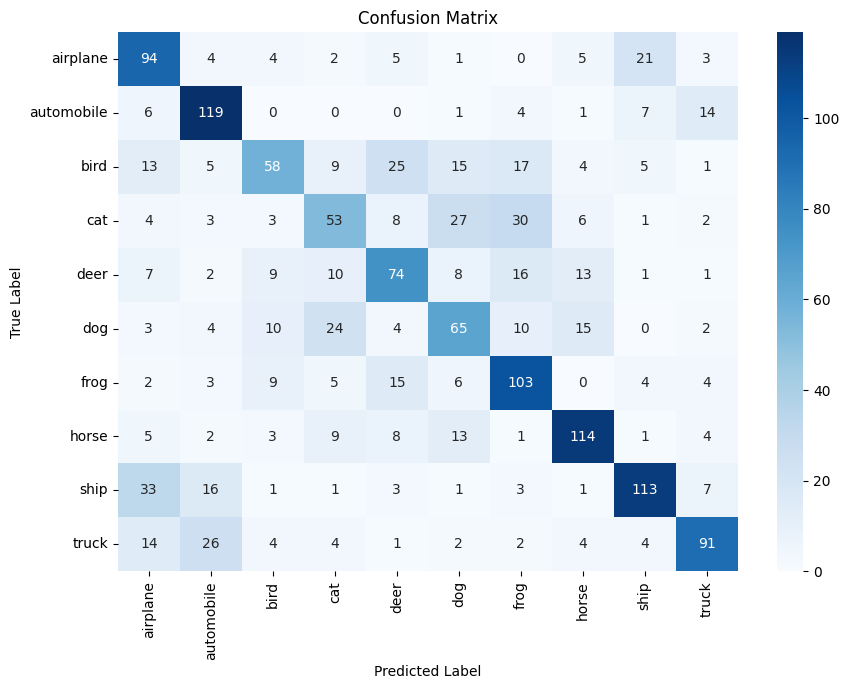

In [5]:
# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get model predictions
y_pred_probabilities = best_model.predict(x_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_probabilities, axis=1) 

# Convert validation observations to one hot vectors
y_true = y_test.squeeze()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [6]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate precision, recall, and f1-score for each class
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# If you want to access precision, recall, and f1-score values separately, you can do it as follows:
precision_recall_f1 = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Extract precision, recall, and f1-score for each class
for class_name in class_names:
    precision = precision_recall_f1[class_name]['precision']
    recall = precision_recall_f1[class_name]['recall']
    f1_score = precision_recall_f1[class_name]['f1-score']
    print(f"For class {class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1_score:.2f}")
    print("---")


              precision    recall  f1-score   support

    airplane       0.52      0.68      0.59       139
  automobile       0.65      0.78      0.71       152
        bird       0.57      0.38      0.46       152
         cat       0.45      0.39      0.42       137
        deer       0.52      0.52      0.52       141
         dog       0.47      0.47      0.47       137
        frog       0.55      0.68      0.61       151
       horse       0.70      0.71      0.71       160
        ship       0.72      0.63      0.67       179
       truck       0.71      0.60      0.65       152

    accuracy                           0.59      1500
   macro avg       0.59      0.59      0.58      1500
weighted avg       0.59      0.59      0.59      1500

For class airplane:
Precision: 0.52
Recall: 0.68
F1-score: 0.59
---
For class automobile:
Precision: 0.65
Recall: 0.78
F1-score: 0.71
---
For class bird:
Precision: 0.57
Recall: 0.38
F1-score: 0.46
---
For class cat:
Precision: 0.45
Recall: 